In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_frame = pd.read_csv('./mnist_train.csv', delimiter=',')
data = data_frame.to_numpy()

labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(60000,)
(60000, 784)


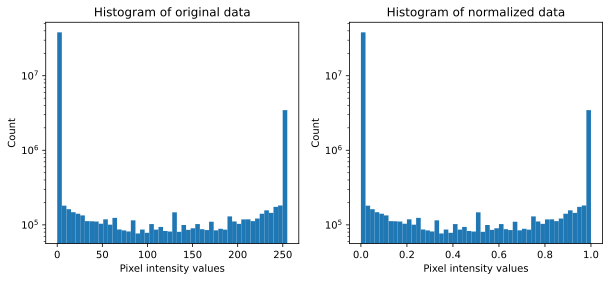

In [3]:
# normalize data to a range of [0, 1]
data_norm = data / np.max(data)

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(), 50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(data_norm.flatten(), 50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

plt.show()

In [4]:
data_tensor = torch.tensor(data_norm).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size=16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [5]:
def create_model():
    class MnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(784,64)
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            
            self.output = nn.Linear(32, 10)
            
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
            return self.output(x)
        
    model = MnistNet()
    
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)
    
    return model, loss_fun, optimizer

In [6]:
model = create_model()[0]

print('Summary of model:')
print(model)
print(' ')

print('Summary of input layer:')
print(vars(model.input))
print(' ')

print('Input layer weights:')
print(model.input.weight.shape)
print(model.input.weight)
print(' ')

Summary of model:
MnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)
 
Summary of input layer:
{'training': True, '_parameters': OrderedDict([('weight', Parameter containing:
tensor([[-0.0087,  0.0182,  0.0120,  ..., -0.0348,  0.0121, -0.0157],
        [ 0.0213,  0.0054, -0.0233,  ..., -0.0324,  0.0269,  0.0317],
        [ 0.0097,  0.0196,  0.0016,  ...,  0.0066,  0.0276,  0.0337],
        ...,
        [-0.0181,  0.0065, -0.0323,  ..., -0.0349,  0.0060, -0.0093],
        [ 0.0092, -0.0004, -0.0132,  ...,  0.0213, -0.0155,  0.0260],
        [ 0.0162,  0.0105,  0.0113,  ...,  0.0081,  0.0272, -0.0091]],
       requires_grad=True)), ('bias', Parameter containing:
tensor([ 0.0298, -0.0164,  0.0058,  0.0148,  0.0317, -0.0029, -0.0194,  0.0159,
        -0.0016, -0.0077, -0.0275,  0.0354, 

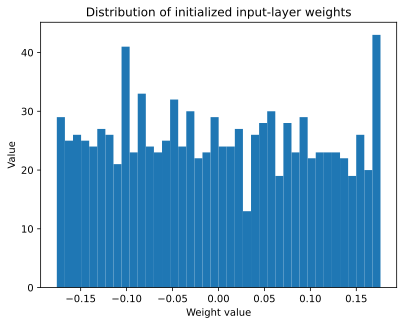

In [7]:
weights = model.fc2.weight.detach().flatten()
plt.hist(weights,40)
plt.xlabel('Weight value')
plt.ylabel('Value')
plt.title('Distribution of initialized input-layer weights')
plt.show()

In [8]:
def weights_histogram(model):
    w = np.array([])
    
    for layer in model.parameters():
        w = np.concatenate((w, layer.detach().flatten().numpy()))
        
    hist_y, hist_x = np.histogram(w, bins=np.linspace(-.8, .8, 101),density=True)
    hist_x = (hist_x[1:]+hist_x[:-1])/2
    return hist_x, hist_y

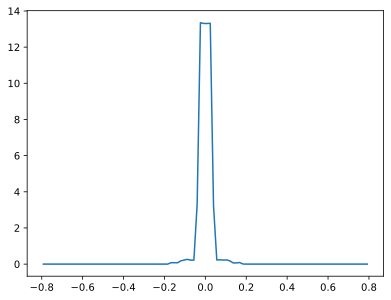

In [9]:
hist_x, hist_y = weights_histogram(model)
plt.plot(hist_x, hist_y)

In [10]:
num_of_epochs = 100
def train_model():
    model, loss_func, optimizer = create_model()
    
    losses = torch.zeros(num_of_epochs)
    train_acc = []
    test_acc = []
    
    hist_x = np.zeros((num_of_epochs,100))
    hist_y = np.zeros((num_of_epochs,100))
    
    for epoch in range(num_of_epochs):
        hist_x, hist_y[epoch, :] = weights_histogram(model)
        
        batch_acc = []
        batch_loss = []
        for X,y in  train_loader:
            yHat = model(X)
            loss = loss_func(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
            matches = torch.argmax(yHat, axis=1) == y
            matches_numeric = matches.float()
            accuracy = 100*torch.mean(matches_numeric)
            batch_acc.append(accuracy)
            
        train_acc.append(np.mean(batch_acc))
        losses[epoch] = np.mean(batch_loss)
        
        X,y = next(iter(test_loader))
        yHat = model(X)
        
        test_acc.append(100*torch.mean((torch.argmax(yHat, axis=1)==y).float()))
        
    return train_acc, test_acc, losses, model, hist_y, hist_x

In [11]:
train_acc, test_acc, losses, model, hist_y, hist_x = train_model()

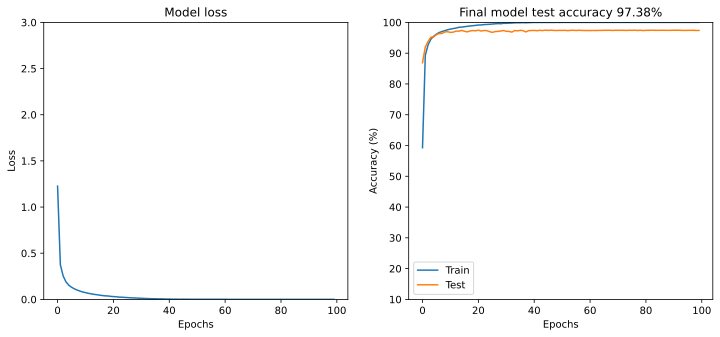

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(train_acc, label='Train')
ax[1].plot(test_acc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy {test_acc[-1]:.2f}%')
ax[1].legend()

plt.show()

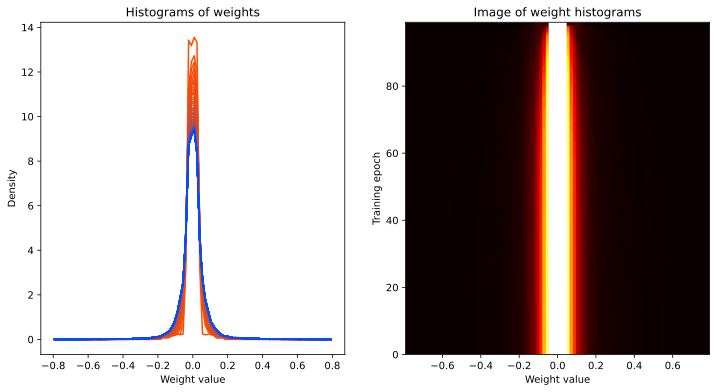

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(hist_y.shape[0]):
    ax[0].plot(hist_x, hist_y[i, :], color=[1-i/100, .3, i/100])
    
ax[0].set_title('Histograms of weights')
ax[0].set_xlabel('Weight value')
ax[0].set_ylabel('Density')

ax[1].imshow(hist_y, vmin=0, vmax=3, extent=[hist_x[0], hist_x[-1], 0 ,99], aspect='auto', origin='upper', cmap='hot')
ax[1].set_xlabel('Weight value')
ax[1].set_ylabel('Training epoch')
ax[1].set_title('Image of weight histograms')

plt.show()

1
2
3
4


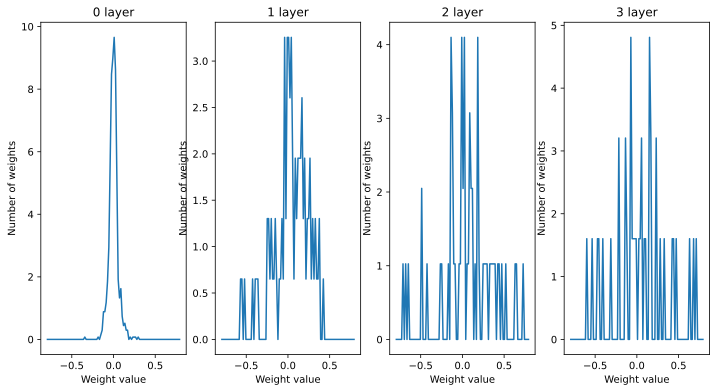

In [14]:
fig, ax = plt.subplots(1,4, figsize=(12, 6))
k=0
for i, layer in enumerate(model.parameters()):
    if i % 2 == 0:
        weights = layer[1].detach().flatten()
    else:
        weights = np.concatenate((weights, layer.detach().flatten()), axis=None)
        hist_y, hist_x = np.histogram(weights, bins=np.linspace(-.8, .8, 101),density=True)
        hist_x = (hist_x[1:]+hist_x[:-1])/2
        ax[k].plot(hist_x, hist_y)
        ax[k].set_xlabel('Weight value')
        ax[k].set_ylabel('Number of weights')
        ax[k].set_title(f'{k} layer')
        k+=1
        print(k)